# SimPeg Forward Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle


# SimPEG imports
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)

from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.utils import plot_1d_layer_model
from discretize import TensorMesh


## Schlumberger Array 
Experiment Setup of the 1D DC resistivity measurements of the layered Earth model. 
Define Schlumberger Array according to min_distance, max_distance, the spacing and the number of measurements. 



In [5]:
def schlumberger_survey(num_measurements, min_ab_distance, max_ab_distance, spacing='log'):
    # Define the 'a' spacing for Schlumberger array measurements for each reading 
    if spacing == 'log': 
        a_b_electrode_separations = np.logspace(np.log10(min_ab_distance), np.log10(max_ab_distance), num_measurements)
        m_n_electrode_separations = 0.01 * a_b_electrode_separations 
    elif spacing == 'lin': 
        a_b_electrode_separations = np.linspace(min_ab_distance, max_ab_distance, num_measurements)
        m_n_electrode_separations = 0.01 * a_b_electrode_separations 
    else:
        raise Exception('Invalid Spacing - needs to be a string of either "log" or "lin" but it was given', spacing)
        
    
    source_list_log = []  # create empty array for sources to live
    
    for ab, mn in zip(a_b_electrode_separations, m_n_electrode_separations):
    
    
        # AB electrode locations for source. Each is a (1, 3) numpy array
        A_location = np.r_[-ab, 0.0, 0.0]
        B_location = np.r_[ab, 0.0, 0.0]
    
        # MN electrode locations for receivers. Each is an (N, 3) numpy array
        M_location = np.r_[-mn, 0.0, 0.0]
        N_location = np.r_[mn, 0.0, 0.0]
    
        # Create receivers list. Define as pole or dipole.
        receiver_list = dc.receivers.Dipole(
            M_location, N_location, data_type="apparent_resistivity"
        )
        receiver_list = [receiver_list]
    
        # Define the source properties and associated receivers
        source_list_log.append(dc.sources.Dipole(receiver_list, A_location, B_location))
    
    # Define survey
    survey = dc.Survey(source_list_log)
    
    electrode_separations = 0.5 * np.sqrt(
        np.sum((survey.locations_a - survey.locations_b) ** 2, axis=1)
        
    )
    return survey, electrode_separations

## Forward model wrapper

According to the survey setup from above we have the electrode spacing. Now we define a wrapper for the acutal forward model such that it receievs and

In [3]:
# Note parameters are composed of resistivities and thicknesses - in that order. First resistivities then thicknesses
def dc_forward_model(resistivities, thicknesses, survey):
        
    # Define mapping from model to 1D layers.
    model_map = maps.IdentityMap(nP=len(resistivities))
    # SimPegs 1D Simulation 
    simulation = dc.simulation_1d.Simulation1DLayers(
        survey=survey,
        rhoMap=model_map,
        thicknesses=thicknesses,
    )
    
    # Predict data for a given model
    pred = simulation.dpred(resistivities)
    return pred

In [4]:
def dc_forward_model_for_sbi (params, survey):
    # Split params into resistivities and thicknesses
    param_length = len(params)
    number_of_layers = int((param_length+1)/2)
    # First half of parameters is resistivities
    resistivities = params[:number_of_layers]
    # Second half of parameters are thicknesses
    thicknesses = params[number_of_layers:]
        
    return dc_forward_model(resistivities, thicknesses, survey)

In [ ]:
# Note parameters are composed of resistivities and thicknesses - in that order. First resistivities then thicknesses
def dc_forward_model_for_sbi_fixed_resistivities(params, survey):
    
    # First half of parameters is resistivities
    resistivities = params
    thicknesses = np.r_[5,10]
    
    # Define mapping from model to 1D layers.
    model_map = maps.IdentityMap(nP=len(resistivities))
    simulation = dc.simulation_1d.Simulation1DLayers(
        survey=survey,
        rhoMap=model_map,
        thicknesses=thicknesses,
    )
    
    # Predict data for a given model
    pred = simulation.dpred(resistivities)
    return pred

## Forward Simulation - Textbook example
The Textbook referred to is "Resistivity and Induced Polarization Theory and Applications to the Near-Surface Earth" 
The example referred to is the one in Chapter 4, Figure 4.9 
In this example we have a three layered earth model with the following resistivity values [500$\Omega m$, 200$\Omega m$, 500$\Omega m$ / 50$\Omega m$].
In this model we assume an infinite base layer and the thickness of the first two layers are 5m for the first layer, 10m for the second layer 

### Logarithmic Scale

In [8]:
num_measurements = 20
min_spacing = 1
max_spacing = 1000
earth_resistivities = [500,200,50]
earth_layer_thicknesses = [5,10,]


textbook_survey, textbook_electrode_spacing = schlumberger_survey(num_measurements, min_spacing, max_spacing)
apparent_resistivities_textbook = dc_forward_model(earth_resistivities, earth_layer_thicknesses, textbook_survey)

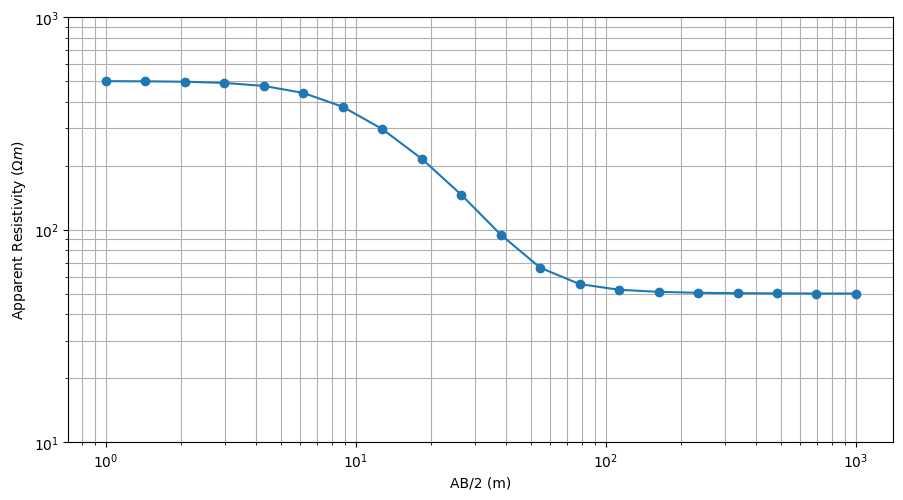

In [11]:
# Plot apparent resistivities on sounding curve# Plot apparent resistivities on sounding curve
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
ax1.loglog(textbook_electrode_spacing, apparent_resistivities_textbook, marker='o', label="$50 \Omega m$) lower unit")
ax1.set_ylim([10, 1000])
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
plt.grid(True, which="both", ls="-")
plt.show()


### Linear Spacing

In [16]:
textbook_survey_lin, textbook_electrode_spacing_lin = schlumberger_survey(20, min_spacing, max_spacing, spacing='lin')
apparent_resistivities_textbook_lin = dc_forward_model(earth_resistivities, earth_layer_thicknesses, textbook_survey_lin)

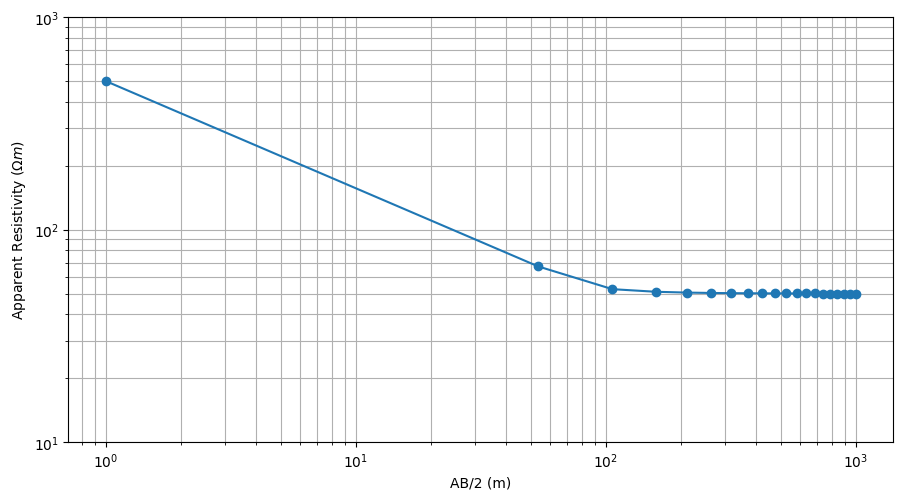

In [17]:
# Plot apparent resistivities on sounding curve# Plot apparent resistivities on sounding curve
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
ax1.loglog(textbook_electrode_spacing_lin, apparent_resistivities_textbook_lin, marker='o', label="$50 \Omega m$) lower unit")
ax1.set_ylim([10, 1000])
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
plt.grid(True, which="both", ls="-")
plt.show()

## SimPeg Least Squares 1D Inversion - Textbook example

Based on the apparent resistivity values measured, or in our case synthetically generated through the forward model, we want to obtain the earth model that led to those measurements. So in our case, we want to detect the resistivities and the layers that have led to our measurements. In the first steps we try to only infer the resistivities with "known" thicknesses of the individual layers as this might be a too complex problem for now


In [22]:
std = 0.02 * np.abs(apparent_resistivities_textbook)
data_object = data.Data(textbook_survey, dobs=apparent_resistivities_textbook, standard_deviation=std)
# Define layer thickness
layer_thicknesses =  np.r_[5,10]
# Define a mesh for plotting and regularization.
mesh = TensorMesh([(np.r_[layer_thicknesses, layer_thicknesses[-1]])], "0")
# Define model. A resistivity (Ohm meters) or conductivity (S/m) for each layer. - here each layer gets the same resistivity assigned
starting_model = np.log(2e2 * np.ones((len(layer_thicknesses) + 1)))  
# Define mapping from model to active cells.
model_map = maps.IdentityMap(nP=len(starting_model)) * maps.ExpMap()

# Define the physics of the problem using the Simulation1DLayers class.
simulation = dc.simulation_1d.Simulation1DLayers(
    survey=textbook_survey,
    rhoMap=model_map,
    thicknesses=layer_thicknesses,
)

In [23]:
# Use L2 norm for data misfit of the weighted residual between observed and predicted
l2_data_misfit = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)
# Define the regularization (model objective function)
reg = regularization.WeightedLeastSquares(
    mesh, alpha_s=1.0, alpha_x=1.0, reference_model=starting_model
)
# Define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.InexactGaussNewton(maxIter=30, maxIterCG=20)

# Define the inverse problem
inv_prob = inverse_problem.BaseInvProblem(l2_data_misfit, reg, opt)

In [24]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)

# Set the rate of reduction in trade-off parameter (beta) each time
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off parameter value.
beta_schedule = directives.BetaSchedule(coolingFactor=5.0, coolingRate=3.0)

# Apply and update sensitivity weighting as the model updates
update_sensitivity_weights = directives.UpdateSensitivityWeights()

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# The directives are defined as a list.
directives_list = [
    update_sensitivity_weights,
    starting_beta,
    beta_schedule,
    save_iteration,
    target_misfit,
]

In [25]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run the inversion
recovered_model = inv.run(starting_model)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayers problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.94e+04  9.48e+04  0.00e+00  9.48e+04    2.32e+05      0              
   1  2.94e+04  3.39e+04  7.76e-01  5.68e+04    2.29e+04      0              
   2  2.94e+04  3.80e+04  6.06e-01  5.58e+04    4.80e+03      0              
   3  5.89e+03  3.69e+04  6.42e-01  4.07e+04    8.23e+04      0              
   4  5.89e+03  1.02e+04  2.85e+00  2.70e+04    6.50e+03      0              
   5  5.89e+03  1.17e+04  2.56e+00  2.68e+04    2.02e+03      0              
   6  1.18e+03  1.11e+04  2.67e+00

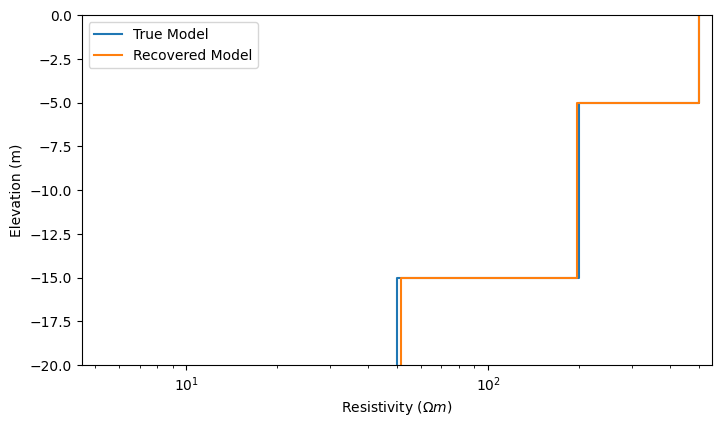

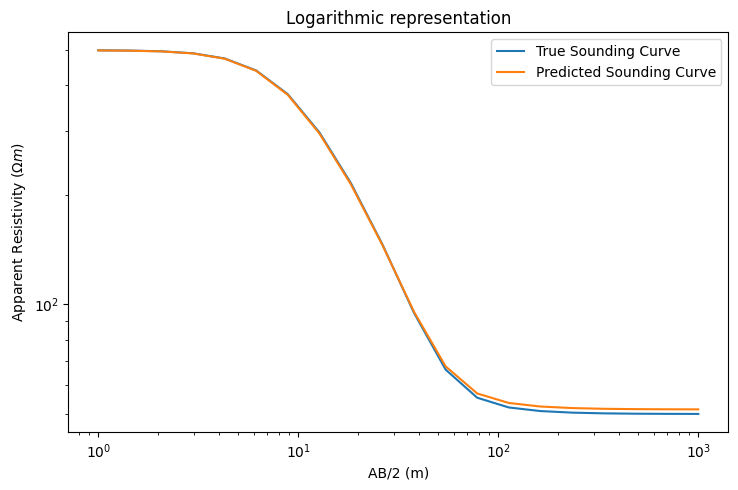

In [29]:
# Define true model and layer thicknesses
true_model = np.r_[500, 200, 50]
true_thickness = np.r_[5.0, 10.0]

# Plot true model and recovered model
fig = plt.figure(figsize=(9, 5))
x_min = np.min([np.min(model_map * recovered_model), np.min(layer_thicknesses)])
x_max = np.max([np.max(model_map * recovered_model), np.max(layer_thicknesses)])

ax1 = fig.add_axes([0.2, 0.15, 0.7, 0.7])
plot_1d_layer_model(true_thickness, true_model, ax=ax1, plot_elevation=True)
plot_1d_layer_model(
    layer_thicknesses,
    model_map * recovered_model,
    ax=ax1,
    plot_elevation=True
)
ax1.set_xlabel(r"Resistivity ($\Omega m$)")
ax1.set_xlim(0.9 * x_min, 1.1 * x_max)
ax1.set_ylim(-20, 0)
ax1.legend(["True Model", "Recovered Model"])

# Plot the true and apparent resistivities on a sounding curve
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.2, 0.1, 0.6, 0.8])
ax1.loglog(textbook_electrode_spacing, apparent_resistivities_textbook)
ax1.loglog(textbook_electrode_spacing, inv_prob.dpred)
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend(["True Sounding Curve", "Predicted Sounding Curve"])
plt.title("Logarithmic representation")
plt.show()
